In [2]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import sys
module_path = os.path.abspath("/workspace/categorical-dsm/")
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir(module_path)

In [3]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

2023-02-12 14:33:59.275069: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-12 14:33:59.275121: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 63c6699003d8
2023-02-12 14:33:59.275248: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 63c6699003d8
2023-02-12 14:33:59.275411: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.29.5
2023-02-12 14:33:59.275436: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.29.5
2023-02-12 14:33:59.275443: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.29.5


In [4]:
physical_devices

[]

In [5]:
# adbench_path = "/workspace/ADBench/"
# # adbench_path = "/workspace/categorical-dsm/adbench_minimal/"
# dagmm_path = "/workspace/categorical-dsm/DAGMM_pytorch/"

# if dagmm_path not in sys.path:
#     sys.path.append(dagmm_path)

# adbench_path = "/workspace/categorical-dsm/adbench_minimal/"
# if adbench_path not in sys.path:
#     sys.path.append(adbench_path)

In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from torchinfo import summary
from models.score_base import TabScoreModel

import seaborn as sns
import matplotlib as mpl

mpl.rc('figure', figsize=(10, 4), dpi=100)
sns.set_theme()

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [7]:
from dataloader import get_dataset, build_tabular_ds
from torch.utils.data import DataLoader
from models.mutils import onehot_to_logit

In [8]:
from configs import census_config as cfg

config = cfg.get_config()
config

data:
  anomaly_label: 50000+.
  categories:
  - 9
  - 17
  - 3
  - 7
  - 24
  - 15
  - 5
  - 10
  - 2
  - 3
  - 6
  - 8
  - 6
  - 6
  - 51
  - 38
  - 8
  - 10
  - 9
  - 10
  - 3
  - 4
  - 5
  - 43
  - 43
  - 43
  - 5
  - 3
  dataset: census
  label_column: class
  numerical_features: 5
device: !!python/object/apply:torch.device
- cpu
devtest: false
eval:
  batch_size: 1024
model:
  act: gelu
  dropout: 0.0
  ema_rate: 0.999
  embedding_type: fourier
  estimate_noise: true
  layers: 20
  name: tab-resnet
  ndims: 1024
  num_scales: 20
  sigma_max: 1.0
  sigma_min: 0.1
  tau_max: 20
  tau_min: 2.0
  time_embedding_size: 128
msma:
  checkpoint: best
  denoise: true
optim:
  beta1: 0.9
  beta2: 0.999
  grad_clip: 1.0
  lr: 0.001
  optimizer: AdamW
  scheduler: cosine
  weight_decay: 0.0001
seed: 42
sweep:
  early_terminate:
    eta: 2
    min_iter: 50000
    s: 3
    type: hyperband
  method: bayes
  metric:
    name: val_loss
  parameters:
    model_act:
      values:
      - gelu
      

In [48]:
sum(config.data.categories)

396

In [ ]:
assert config.data.dataset == "census"

In [11]:
workdir = f"/workspace/categorical-dsm/results/{config.data.dataset}/"
workdir

'/workspace/categorical-dsm/results/census/'

In [33]:
from ood_detection_helper import auxiliary_model_analysis

def get_msma_results(workdir, ckpt_num=-1, seed=0):
    #TODO: USE PYOD MODELS!
    np.random.seed(42)
    workdir = os.path.join(workdir, f"seed_{seed}")
    denoise = config.msma.denoise
    ckpt_dir = os.path.join(workdir, "checkpoints")
    ckpts = sorted(os.listdir(ckpt_dir))
    ckpt = ckpts[ckpt_num]
    step = ckpt.split("-")[0]
    fname = os.path.join(
            workdir, "score_norms", f"{step}-{'denoise' if denoise else ''}-score_norms.npz"
        )
    with np.load(fname, allow_pickle=True) as npzfile:
        outdict = {k: npzfile[k].item() for k in npzfile.files}


    X_train = outdict["train"]["score_norms"]
    np.random.shuffle(X_train)
    X_val = outdict["val"]["score_norms"]
    X_train = np.concatenate((X_train[::2], X_val))
    test_labels = outdict["test"]["labels"]
    X_test = outdict["test"]["score_norms"][test_labels == 0]
    X_ano = outdict["test"]["score_norms"][test_labels == 1]
    results = auxiliary_model_analysis(X_train, X_test, [X_ano],
                                    components_range=range(3,11,2),
                                    labels=["Train", "Inlier", "Outlier"])
    
    return results

In [36]:
baseline_metrics = pd.read_csv(f"results/{config.data.dataset}_baseline_metrics.csv", index_col=0)
baseline_metrics[["roc_auc", "ap", "model"]].groupby('model').describe()

roc_auc                                                         \
          count       mean        std        min        25%        50%   
model                                                                    
DAGMM       5.0  32.614439  13.578103  11.503525  29.133574  37.070841   
DSVDD       5.0  51.818167   3.418323  47.248022  50.120614  51.385751   
ECOD        5.0  56.049101   0.241130  55.815883  55.948228  55.948902   
IForest     5.0  55.782145   3.202342  53.154118  53.295102  54.685031   

                                 ap                                  \
               75%        max count       mean       std        min   
model                                                                 
DAGMM    37.339082  48.025172   5.0  32.896435  4.998012  25.516484   
DSVDD    54.756491  55.579959   5.0  41.179291  3.441802  36.852305   
ECOD     56.087829  56.444662   5.0  40.961150  0.147001  40.808991   
IForest  56.960961  60.815515   5.0  40.635879  2.068457  38.834303   

                                                     
               25%        50%        75%        max  
model                                                
DAGMM    31.305573  33.561174  35.050892  39.048053  
DSVDD    39.276095  40.416085  44.638470  44.713499  
ECOD     40.839225  40.977461  41.003636  41.176435  
IForest  39.026042  40.029096  41.454245  43.835707

========================= Training GMM =========================
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 29.257319 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 9}
---------------------------------------------------------------------------
27.200074 (0.122644) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 3}
27.114310 (0.131638) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
28.735450 (0.195343) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 7}
29.257319 (0.408915) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 9}


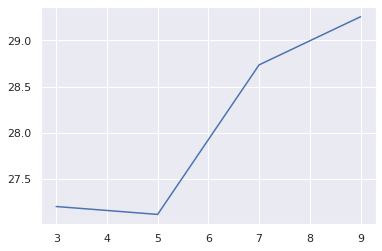

---Likelihoods---
Training: 46.683
Inlier: 46.490
Outlier: 42.999
========================= Training KD Tree =========================
========================= Training GMM =========================
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 35.022183 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 9}
---------------------------------------------------------------------------
32.824545 (0.064269) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 3}
33.447517 (0.186261) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
34.670071 (0.521028) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 7}
35.022183 (0.211132) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_

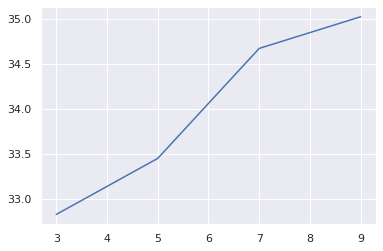

---Likelihoods---
Training: 50.178
Inlier: 50.065
Outlier: 46.132
========================= Training KD Tree =========================
========================= Training GMM =========================
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 32.871722 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 9}
---------------------------------------------------------------------------
31.050580 (0.055575) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 3}
31.385194 (0.227089) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
31.736040 (0.109360) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 7}
32.871722 (0.121108) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_

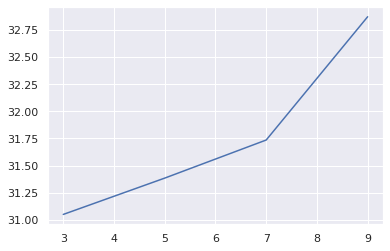

---Likelihoods---
Training: 45.558
Inlier: 45.524
Outlier: 42.900
========================= Training KD Tree =========================
========================= Training GMM =========================
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 37.736698 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 9}
---------------------------------------------------------------------------
33.033816 (0.034537) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 3}
35.137412 (0.102126) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
37.663940 (0.061255) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 7}
37.736698 (0.079181) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_

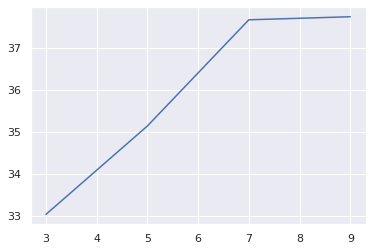

---Likelihoods---
Training: 52.788
Inlier: 52.817
Outlier: 48.088
========================= Training KD Tree =========================
========================= Training GMM =========================
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 36.248786 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 9}
---------------------------------------------------------------------------
33.387208 (0.124299) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 3}
35.311035 (0.184241) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
35.668201 (0.306369) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 7}
36.248786 (0.244603) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_

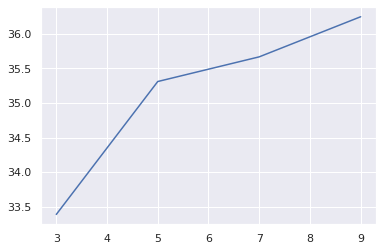

---Likelihoods---
Training: 52.274
Inlier: 52.209
Outlier: 48.691
========================= Training KD Tree =========================


In [37]:
all_metrics = []
for i in range(5):
    msma_results = get_msma_results(workdir, seed=i)
    all_metrics.append(msma_results)

In [50]:
gmm_metrics  = pd.concat(m["GMM"]["metrics"].reset_index(drop=True) for m in all_metrics
                        ).reset_index(drop=True)
gmm_metrics['seed'] = np.arange(5)
gmm_metrics['model'] = "MSMA-GMM"
gmm_metrics.describe()

,ap,de,fpr_tpr80,fpr_tpr95,pr_auc_in,pr_auc_out,roc_auc,seed
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,47.792630,38.002172,72.779025,72.779025,47.785399,76.897037,63.869265,2.000000
std,2.291253,1.228820,2.503922,2.503922,2.290204,1.054484,1.936832,1.581139
min,44.235141,36.667544,70.011756,70.011756,44.229606,75.733721,61.354071,0.000000
25%,46.996363,36.914696,71.369029,71.369029,46.989254,76.087347,62.526329,1.000000
50%,48.721261,38.044614,71.639771,71.639771,48.713012,76.693814,64.224695,2.000000
75%,48.804658,38.843457,75.405222,75.405222,48.797861,77.863563,65.066178,3.000000
max,50.205727,39.540547,75.469346,75.469346,50.197263,78.106737,66.175053,4.000000


In [51]:
kd_metrics  = pd.concat(m["KD"]["metrics"].reset_index(drop=True) for m in all_metrics
                       ).reset_index(drop=True)
kd_metrics['seed'] = np.arange(5)
kd_metrics['model'] = "MSMA-KD"


kd_metrics.describe()

,ap,de,fpr_tpr80,fpr_tpr95,pr_auc_in,pr_auc_out,roc_auc,seed
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,49.038507,35.449570,67.854369,67.854369,49.093753,78.630877,65.930015,2.000000
std,1.415288,0.094925,0.090565,0.090565,1.416668,0.432758,0.959797,1.581139
min,46.945386,35.358966,67.724698,67.724698,46.997409,78.167275,64.854226,0.000000
25%,48.490322,35.386452,67.828008,67.828008,48.545391,78.220099,65.110172,1.000000
50%,49.440400,35.410285,67.838695,67.838695,49.496896,78.762825,66.213271,2.000000
75%,49.583101,35.503174,67.927755,67.927755,49.641120,78.811781,66.248731,3.000000
max,50.733323,35.588974,67.952691,67.952691,50.787948,79.192408,67.223677,4.000000


In [52]:
# save the results
df_metrics = pd.concat([gmm_metrics, kd_metrics, baseline_metrics])
df_metrics[["roc_auc", "ap", "model"]].groupby('model').describe()

roc_auc                                                         \
           count       mean        std        min        25%        50%   
model                                                                     
DAGMM        5.0  32.614439  13.578103  11.503525  29.133574  37.070841   
DSVDD        5.0  51.818167   3.418323  47.248022  50.120614  51.385751   
ECOD         5.0  56.049101   0.241130  55.815883  55.948228  55.948902   
IForest      5.0  55.782145   3.202342  53.154118  53.295102  54.685031   
MSMA-GMM     5.0  63.869265   1.936832  61.354071  62.526329  64.224695   
MSMA-KD      5.0  65.930015   0.959797  64.854226  65.110172  66.213271   

                                  ap                                  \
                75%        max count       mean       std        min   
model                                                                  
DAGMM     37.339082  48.025172   5.0  32.896435  4.998012  25.516484   
DSVDD     54.756491  55.579959   5.0  41.179291  3.441802  36.852305   
ECOD      56.087829  56.444662   5.0  40.961150  0.147001  40.808991   
IForest   56.960961  60.815515   5.0  40.635879  2.068457  38.834303   
MSMA-GMM  65.066178  66.175053   5.0  47.792630  2.291253  44.235141   
MSMA-KD   66.248731  67.223677   5.0  49.038507  1.415288  46.945386   

                                                      
                25%        50%        75%        max  
model                                                 
DAGMM     31.305573  33.561174  35.050892  39.048053  
DSVDD     39.276095  40.416085  44.638470  44.713499  
ECOD      40.839225  40.977461  41.003636  41.176435  
IForest   39.026042  40.029096  41.454245  43.835707  
MSMA-GMM  46.996363  48.721261  48.804658  50.205727  
MSMA-KD   48.490322  49.440400  49.583101  50.733323

In [64]:
df_stats = df_metrics.groupby('model').describe()

for metric in ["ap", "roc_auc"]:
    latex_str = [metric]
    latex_str.append(f"{ano_ratio:.2f}")
    df = df_stats.loc[["IForest","ECOD","DAGMM","DSVDD","MSMA-GMM"], metric]
    best =  df["mean"].max()
    for m in df[["mean", "std"]].values:
        _str = f"{m[0]:.2f} \pm~{m[1]:.2f}" 
        if np.isclose(m[0], best):
            _str = "\B "+_str
        latex_str.append(_str)
    latex_str = " & ".join(latex_str)
    print(latex_str)

ap & 0.40 & 40.64 \pm~2.07 & 40.96 \pm~0.15 & 32.90 \pm~5.00 & 41.18 \pm~3.44 & \B 47.79 \pm~2.29
roc_auc & 0.40 & 55.78 \pm~3.20 & 56.05 \pm~0.24 & 32.61 \pm~13.58 & 51.82 \pm~3.42 & \B 63.87 \pm~1.94


In [63]:
num_anos = len(all_metrics[0]["GMM"]["ood_scores"].ravel())
num_inliers = len(all_metrics[0]["GMM"]["test_scores"].ravel())
ano_ratio = num_anos / (num_anos+num_inliers)
print(f"Anomaly ratio for test set of {config.data.dataset}: {num_anos}/{num_inliers+num_anos} = {ano_ratio:.2f}")

Anomaly ratio for test set of census: 18568/46639 = 0.40


In [61]:
all_metrics[0]["GMM"]["ood_scores"]

(1, 18568)

In [ ]:
df_melt = df_metrics.drop(columns="seed").melt(id_vars="model", var_name="metric")
df_melt

In [ ]:
sns.catplot(data=df_melt.query("metric=='roc_auc'"), x="metric", y="value", hue="model", kind="bar")

In [ ]:
sns.catplot(data=df_melt.query("metric=='ap'"), x="metric", y="value", hue="model", kind="bar")